In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("HCM_weather_42023_42024.csv")
dftest = pd.read_csv('HCM_weather_42023_42024_test.csv')



In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

# Trích xuất các thành phần từ cột datetime
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

In [5]:
features = df[['feelslike', 'dew', 'humidity', 'windgust', 'winddir', 'solarradiation', 'visibility', 'cloudcover', 'month', 'hour']]
labels = df['temp']

In [6]:
X_train, y_train =features.values, labels.values
X_train.shape, y_train.shape

((9504, 10), (9504,))

In [7]:
scalers = {}
features_ = ['feelslike', 'dew', 'humidity', 'windgust', 'winddir', 'solarradiation', 'visibility', 'cloudcover', 'month', 'day']
for i, feature in enumerate(features_):
    #scalers[feature] = MinMaxScaler(feature_range=(0, 1))
    scalers[feature] = StandardScaler()
    X_train[:, i] = scalers[feature].fit_transform(X_train[:,i].reshape(-1, 1)).reshape(-1)


In [10]:
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x_ = X[i:i+seq_length]
        y_ = y[i+seq_length]  # Dự đoán lượng mưa
        xs.append(x_)
        ys.append(y_)
    return np.array(xs), np.array(ys)

seq_length = 20 # Sử dụng 20 giờ để dự đoán giờ tiếp theo
X_seq, y_seq = create_sequences(X_train, y_train, seq_length)

In [11]:
X_train = torch.tensor(X_seq, dtype=torch.float32)
y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)

In [12]:
X_train.shape

torch.Size([9484, 20, 10])

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [14]:
X_train=X_train.to(device)
print(X_train.shape)
y_train=y_train.to(device)
class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_layer_size=512, output_size=1, n_layers=1):
        super(WeatherRNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, 1, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device) 
        #h0 là kích thước của toàn bộ hidden(# lớp hidden, số time step, size của mỗi timestep)
        out, hn = self.rnn(input_seq, h0)
        # số cụm, 24, 9
        out = self.linear(out[:, -1, :])
        
        return out

input_size = len(features_)
model = WeatherRNN(input_size).to(device)
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_function(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


torch.Size([9484, 20, 10])
Epoch 0, Loss: 29.138696670532227
Epoch 100, Loss: 6.070045471191406
Epoch 200, Loss: 2.1512768268585205
Epoch 300, Loss: 0.8894159197807312
Epoch 400, Loss: 0.7066817879676819
Epoch 500, Loss: 0.6644251942634583
Epoch 600, Loss: 0.6303276419639587
Epoch 700, Loss: 0.6086217761039734
Epoch 800, Loss: 0.5925964117050171
Epoch 900, Loss: 0.5708107352256775


In [ ]:
torch.save(model, 'modelRNN.pth')

In [ ]:
# modelx = WeatherRNN(input_size, hidden_layer_size=512, output_size=1, n_layers=1)

# modelx = torch.load('modelRNN.pth')

In [16]:
dftest['datetime'] = pd.to_datetime(dftest['datetime'], utc=True)

# Trích xuất các thành phần từ cột datetime
dftest['month'] = dftest['datetime'].dt.month
dftest['hour'] = dftest['datetime'].dt.hour
features_test = dftest[['feelslike', 'dew', 'humidity', 'windgust', 'winddir', 'solarradiation', 'visibility', 'cloudcover', 'month', 'hour']]
labels_test = dftest['temp']
X_test, y_test =features_test.values, labels_test.values


In [17]:
for i, feature in enumerate(features_):
    X_test[:, i] = scalers[feature].transform(X_test[:,i].reshape(-1, 1)).reshape(-1)

In [18]:
X_seq_test, y_seq_test = create_sequences(X_test, y_test, seq_length)

In [19]:
X_test_t = torch.tensor(X_seq_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_seq_test, dtype=torch.float32).unsqueeze(1).to(device)

In [20]:
y_test_t.shape

torch.Size([772, 1])

In [22]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_t)
predictions = predictions.cpu()
print('accuracy: ', mean_absolute_error(y_test_t.cpu(), predictions))


accuracy:  0.744728


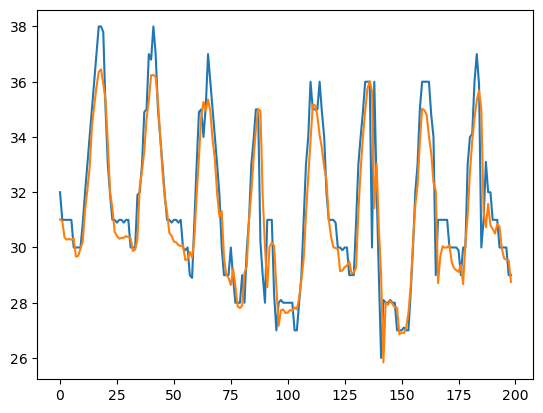

In [23]:

plt.plot(np.arange(199), y_test_t.cpu())
plt.plot(np.arange(199), predictions.cpu())
plt.show()

In [1]:
!jupyter nbconvert --to script RNN_Timesr_Weather.ipynb

[NbConvertApp] Converting notebook RNN_Timesr_Weather.ipynb to script
[NbConvertApp] Writing 4717 bytes to RNN_Timesr_Weather.py
